<a href="https://colab.research.google.com/github/yuraoh12/AI-bigdata/blob/main/231123_seg_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
# Dataset : https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data

In [ ]:
os.environ['KAGGLE_USERNAME'] = '' # username
os.environ['KAGGLE_KEY'] = '' # key
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

 98% 1.01G/1.03G [00:08<00:00, 180MB/s]
100% 1.03G/1.03G [00:08<00:00, 131MB/s]


In [ ]:
!unzip finding-lungs-in-ct-data.zip

Archive:  finding-lungs-in-ct-data.zip
  inflating: 2d_images.zip           
  inflating: 2d_images/ID_0000_Z_0142.tif  
  inflating: 2d_images/ID_0001_Z_0146.tif  
  inflating: 2d_images/ID_0002_Z_0162.tif  
  inflating: 2d_images/ID_0003_Z_0132.tif  
  inflating: 2d_images/ID_0004_Z_0066.tif  
  inflating: 2d_images/ID_0005_Z_0066.tif  
  inflating: 2d_images/ID_0006_Z_0206.tif  
  inflating: 2d_images/ID_0007_Z_0211.tif  
  inflating: 2d_images/ID_0008_Z_0065.tif  
  inflating: 2d_images/ID_0009_Z_0114.tif  
  inflating: 2d_images/ID_0010_Z_0259.tif  
  inflating: 2d_images/ID_0011_Z_0156.tif  
  inflating: 2d_images/ID_0012_Z_0167.tif  
  inflating: 2d_images/ID_0013_Z_0047.tif  
  inflating: 2d_images/ID_0014_Z_0116.tif  
  inflating: 2d_images/ID_0015_Z_0136.tif  
  inflating: 2d_images/ID_0016_Z_0208.tif  
  inflating: 2d_images/ID_0017_Z_0061.tif  
  inflating: 2d_images/ID_0018_Z_0069.tif  
  inflating: 2d_images/ID_0019_Z_0088.tif  
  inflating: 2d_images/ID_0020_Z_0070.tif  

In [ ]:
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


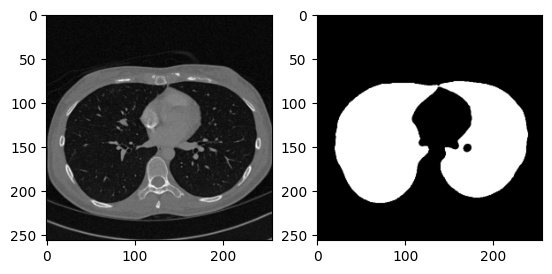

In [ ]:
# preprocessing
IMG_SIZE = 256

x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_data[i] = img

for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img

y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

In [ ]:
!git clone https://github.com/kairess/CT_lung_segmentation.git

Cloning into 'CT_lung_segmentation'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Receiving objects: 100% (17/17), 35.49 MiB | 14.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)

np.save('/content/CT_lung_segmentation/dataset/x_train.npy', x_train)
np.save('/content/CT_lung_segmentation/dataset/y_train.npy', y_train)
np.save('/content/CT_lung_segmentation/dataset/x_val.npy', x_val)
np.save('/content/CT_lung_segmentation/dataset/y_val.npy', y_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


In [ ]:
# Train
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [ ]:
x_train = np.load('/content/CT_lung_segmentation/dataset/x_train.npy')
y_train = np.load('/content/CT_lung_segmentation/dataset/y_train.npy')
x_val = np.load('/content/CT_lung_segmentation/dataset/x_val.npy')
y_val = np.load('/content/CT_lung_segmentation/dataset/y_val.npy')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


In [ ]:
# Model
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Epoch 1/100


In [ ]:
# Evaluation
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

In [ ]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray') # input
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray') # 정답
    ax[i, 2].imshow(pred.squeeze(), cmap='gray') # 예측